## Exercise 5: Tabular Q-learning

In this exercise, you will implement tabular Q-Learning and solve the Cliff Walking environment.

### 1. RL Environment

As described in the lecture, an *agent* observes the *state* $s_t$ of an environment by selecting an *action* $a_t$. Additionally, for every step the agent receives a reward $r_t$. In the following, you can see how to interact with an RL environment programmatically:

In [3]:
import gymnasium as gym

env = gym.make("CliffWalking-v0", render_mode="rgb_array")  # We create the Cliff Walking environment.
obs = env.reset()  # Start of the episode, the agent receives an initial state.

action = 0  # We take an examplary action.
obs, reward, terminated, _, _ = env.step(action)  # The environment transitions to a new state.

##### Cliff Walking Environment
For this exercise, we want to solve the classical *Cliff Walking* environment, where an agent must walk to the other side of an cliff:

<img src="img/cliff_walking_sutton.png" alt="Drawing" style="width: 700px;" align="center"/>

For every step the agent takes, he receives a reward of $-1$. When the agent falls of the cliff he must start from the beginning and receives a reward of $-100$.


The current state of the environment can be rendered:

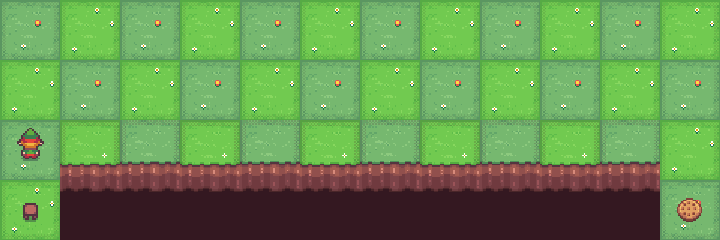

In [4]:
from PIL import Image

img = env.render()
Image.fromarray(img)

### 2. Q-learning

Before starting this section, it might be helpful to go back to slides of the lecture to read the core concepts behind Q-learning. In this section, you have two tasks:
* In `TASK 1` you have to implement the $\epsilon$-greedy action selection.
* In `TASK 2` you should implement the Q-learning update.

#####  $\epsilon$-greedy policy

In the following, you have to implement the epsilon greedy policy of the lecture.

In [5]:
import numpy as np


def make_epsilon_greedy_policy(Q, epsilon: float, nA: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
      Q: A dictionary that maps from state -> action-values.
        Each value is a numpy array of length nA (see below)
      epsilon: The probability to select a random action.
      nA: Number of actions in the environment.

    Returns:
      A function that takes the observation as an argument and returns
      the greedy action in form of an int.
    """

    def policy_fn(observation):
        # TODO: TASK 1 - Implement the greedy policy, this function
        #       should return an int.
        if np.random.uniform() < epsilon:
            return np.random.randint(0, nA)
        return Q[observation].argmax()

    return policy_fn

##### Implementing Q-learning
As a last step, implement the Q-learning update rule!

In [8]:
from collections import defaultdict, namedtuple
import itertools
import sys


EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy

    Args:
      env: environment.
      num_episodes: Number of episodes to run for.
      discount_factor: Lambda time discount factor.
      alpha: TD learning rate.
      epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
      A tuple (Q, episode_lengths).
      Q is the optimal action-value function, a dictionary mapping state -> action values.
      stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.unwrapped.nA))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
    )
    
    # Create policy
    policy = make_epsilon_greedy_policy(Q, epsilon, env.unwrapped.nA)

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and receive initial state.
        state, _ = env.reset()
        
        for t in itertools.count():
            action = policy(state)

            # Transition of the environment.
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1

            # TODO: TASK 2 - Implement the TD Update.

            #  Q[state][action] += ???
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * (1 - terminated) * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta


            # Check whether the episode is finished.
            if terminated or truncated:
                break

            state = next_state

    return Q, stats

##### Let the learning begin
When everything is correctly implemented, you start with the learning, by running the cell below :)

In [9]:
Q, stats = q_learning(env, 500)

Episode 500/500.

Let us now see what the learned policy does. If you want you can change the epsilon to different values.

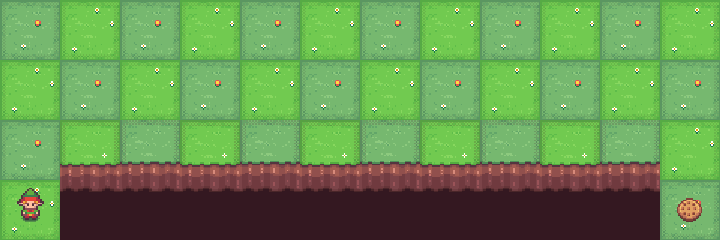

In [13]:
from visualization import save_rgb_animation
from IPython.display import Image as IImage


def rendered_rollout(policy, env, max_steps=20):
    steps = 0
    
    state, _ = env.reset()
    imgs = [env.render()]

    while steps < max_steps:
        action = policy(state)
        state, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        steps += 1

        if terminated or truncated:
            break
    
    return imgs

policy = make_epsilon_greedy_policy(Q, epsilon=0., nA=env.unwrapped.nA)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "cliff_walk.gif")
IImage(filename="cliff_walk.gif")

### 4.3 Convergence of Q-learning

Given the `stats` of the last section, you can visualize the episode length and the epsiode reward, the agent achieved over training. The episode reward is the sum of all rewards collected in one episode.

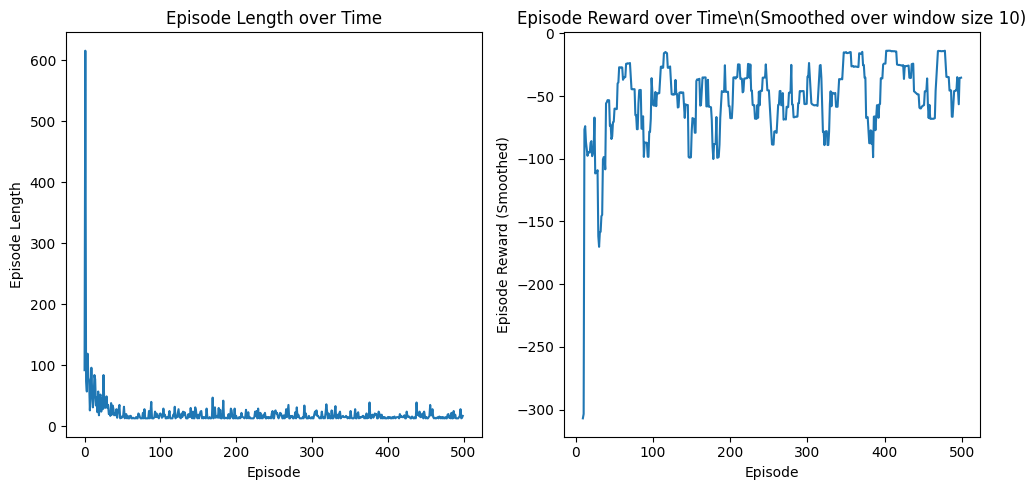

In [11]:
from visualization import plot_episode_stats

plot_episode_stats(stats)

We can also derive the state value function from our final Q-value estimates, thus $V (s) = \max_a Q(s, a)$. In this case, this is just the number of steps to the goal state:

In [12]:
from visualization import plot_cliff_q
plot_cliff_q(Q)

-12.14	-11.57	-10.89	-10.09	-9.28	-8.48	-7.58	-6.77	-5.84	-4.90	-3.97	-3.00
-12.80	-11.98	-11.00	-10.00	-9.00	-8.00	-7.00	-6.00	-5.00	-4.00	-3.00	-2.00
-12.00	-11.00	-10.00	-9.00	-8.00	-7.00	-6.00	-5.00	-4.00	-3.00	-2.00	-1.00
-13.00	-inf	-inf	-inf	-inf	-inf	-inf	-inf	-inf	-inf	-inf	0.00


> **Question:** Why is there a discrepency between the epsiode reward from the plot before and the Q-value of the starting position, which is at the bottom left?

> **Answer:** Because during training we see the performance of the behaviour policy, we use for exploring. Over time the agent learns to walk as closely as possible to the cliff, thus the $\epsilon$-greedy exploration becomes fatal.

If you still have some time left, you can also play around with some other [discrete environments](https://gymnasium.farama.org/environments/toy_text/frozen_lake/).